In [1]:
%matplotlib inline
from __future__ import absolute_import, division, print_function, unicode_literals
from builtins import range

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style("white")

from functools import partial
from joblib import delayed, Parallel
from mmit import MaxMarginIntervalTree
from mmit.core.solver import compute_optimal_costs
from mmit.metrics import mean_squared_error, zero_one_loss
from mmit.model import TreeExporter
from mmit.model_selection import GridSearchCV
from os import listdir, mkdir, system
from os.path import abspath, basename, exists, join
from shutil import rmtree as rmdir
from time import time

cool_contrasting_cmap = np.array(['#9FB2A4', '#5B4E51', '#997D87', '#15A08A', '#A079BF', '#00005F', '#A1C299', '#89412E', '#BCB1E5', '#47675D', '#76912F', '#885578', '#99ADC0', '#1BE177', '#404E55', '#789EC9', '#FF1A59', '#FFFFFE', '#061203', '#FF6832', '#D20096', '#8ADBB4', '#0060CD', '#63FFAC', '#A45B02', '#B79762', '#BEC459', '#A3A489', '#456D75', '#CA834E', '#59738A', '#E7AB63', '#3B9700', '#D7BFC2', '#3E89BE', '#B4A8BD', '#FFB500', '#658188', '#CCB87C', '#0086ED', '#886F4C', '#A4E804', '#8BB400', '#00846F', '#D16100', '#66796D', '#6A714A', '#5B656C', '#61615A', '#6367A9', '#252F99', '#1E6E00', '#C0B9B2', '#66E1D3', '#BC65E9', '#643127', '#518A87', '#C2FFED', '#92896B', '#837393', '#DA007C', '#E20027', '#6A3A4C', '#575329', '#A38469', '#F7C9BF', '#E773CE', '#B903AA', '#001C1E', '#00C6C8', '#797868', '#636375', '#FF90C9', '#004D43', '#E83000', '#D25B88', '#8FB0FF', '#00A6AA', '#FDE8DC', '#D0AC94', '#006A66', '#006C31', '#FFFF00', '#E4FFFC', '#6F0062', '#003109', '#BDC9D2', '#BE4700', '#BA0900', '#222800', '#943A4D', '#EEC3FF', '#0CBD66', '#7900D7', '#5EFF03', '#B77B68', '#000035', '#0AA6D8', '#D790FF', '#6B002C', '#FF913F', '#7A87A1', '#5B113C', '#391406', '#29201D', '#300018', '#402334', '#953F00', '#001E09', '#34362D', '#71BB8C', '#00B57F', '#83A485', '#5A0007', '#671190', '#A97399', '#A05837', '#FFDBE5', '#201625', '#3D4F44', '#320033', '#001325', '#9B9700', '#FC009C', '#CC0744', '#FAD09F', '#549E79', '#A88C85', '#8D8546', '#203B3C', '#04F757', '#6C8F7D', '#0AA3F7', '#013349', '#FEFFE6', '#FFA0F2', '#674E60', '#02684E', '#7C6571', '#1B4400', '#98D058', '#FEB2C6', '#372101', '#29607C', '#7A7BFF', '#006FA6', '#F5E1FF', '#C8A1A1', '#5B4534', '#365D25', '#C895C5', '#324E72', '#1E0200', '#788D66', '#958A9F', '#FF2F80', '#2F5D9B', '#866097', '#4A3B53', '#3B000A', '#004B28', '#4C6001', '#6C5E46', '#938A81', '#B5D6C3', '#7E6405', '#CB7E98', '#9C6966', '#78AFA1', '#DDEFFF', '#72418F', '#6B94AA', '#D157A0', '#BF5650', '#D83D66', '#D68E01', '#FF4A46', '#BC23FF', '#9FA064', '#353339', '#F4ABAA', '#374527', '#DFFB71', '#6B3A64', '#868E7E', '#00C2A0', '#3C3E6E', '#B5F4FF', '#5EBCD1', '#FFF69F', '#FFAA92', '#FF34FF', '#1A3A2A', '#64547B', '#7A4900', '#83AB58', '#A77500', '#A3C8C9', '#C2FF99', '#AA5199', '#A74571', '#D1F7CE', '#A30059', '#8CD0FF', '#806C66', '#012C58', '#9695C5', '#B88183', '#008941', '#3B5DFF', '#C8D0F6', '#D86A78', '#7ED379', '#6D80BA', '#7D5A44', '#00CCFF', '#452C2C', '#494B5A', '#9556BD', '#456648', '#EA8B66', '#4B8160', '#1CE6FF', '#895563', '#00FECF', '#A3F3AB', '#C86240', '#02525F', '#00D891', '#00489C', '#55813B', '#7B4F4B', '#0000A6', '#E98176', '#B894A6', '#D2DCD5', '#E704C4', '#4FC601', '#5B3213', '#772600', '#97979E', '#A76F42', '#DDB6D0', '#F4D749', '#51A058', '#75797C', '#B05B6F', '#809693', '#0045D2', '#C6005A', '#3A2465', '#FF8A9A', '#0089A3', '#DBD5DD', '#1D1702', '#FF5DA7', '#545C46', '#6B7900', '#9F94F0', '#513A01', '#453C23', '#C6DC99', '#3A3F00', '#00B433', '#922329', '#CCAA35', '#CFCDAC', '#962B75'])

In [2]:
class Dataset(object):
    def __init__(self, path):
        self.path = path
        feature_data = pd.read_csv(join(path, "features.csv"))
        self.X = feature_data.values
        self.feature_names = feature_data.columns.values
        del feature_data
        self.y = pd.read_csv(join(path, "targets.csv")).values
        self.folds = pd.read_csv(join(path, "folds.csv")).values.reshape(-1, )
        self.name = basename(path)
    
    @property
    def n_examples(self):
        return self.X.shape[0]
    
    @property
    def n_features(self):
        return self.X.shape[1]
    
def find_datasets(path):
    for d in listdir(path):
        if exists(join(path, d, "features.csv")) and \
           exists(join(path, d, "targets.csv")) and \
           exists(join(path, d, "folds.csv")):
            yield Dataset(abspath(join(path, d)))

datasets = list(find_datasets("./data"))

In [3]:
def evaluate_on_dataset(d, metric, result_dir, pruning=True, n_cpu=-1):
    start_time = time()
    
    ds_result_dir = join(result_dir, d.name)
    if not exists(ds_result_dir):
        mkdir(ds_result_dir)
    
    fold_models = []
    fold_predictions = np.zeros(d.n_examples)
    fold_best_params = []
    fold_cv_results = []
    for fold in np.unique(d.folds):
        fold_train = d.folds != fold
        
        X_train = d.X[fold_train]
        y_train = d.y[fold_train]
        X_test = d.X[~fold_train]
        y_test = d.y[~fold_train]
        
        cv = GridSearchCV(estimator=MaxMarginIntervalTree(), param_grid=params, cv=10, n_jobs=n_cpu, 
                          scoring=metric)
        cv.fit(X_train, y_train, d.feature_names)
        fold_predictions[~fold_train] = cv.predict(X_test)
        fold_models.append(cv.best_estimator_)
        fold_best_params.append(cv.best_params_)
        fold_cv_results.append(cv.cv_results_)
        
    print("MSE:", mean_squared_error(d.y, fold_predictions))
    print("ACC:", 1.0 - zero_one_loss(d.y, fold_predictions))
    open(join(ds_result_dir, "predictions.csv"), "w").write("\n".join(str(x) for x in fold_predictions))
    
    latex_exporter = TreeExporter("latex")
    string_exporter = TreeExporter("string")
    f_models = open(join(ds_result_dir, "models.tsv"), "w")
    for i, m in enumerate(fold_models):
        open(join(ds_result_dir, "model_fold_{0:d}.tex".format(i + 1)), "w").write(latex_exporter(m))
        f_models.write("{0:d}\t{1!s}\n".format((i + 1), string_exporter(m)))
    f_models.close()
    print("Took", time() - start_time, "seconds.")
    
    # Generate the PDF file for each tree
    #build_cmd = "cd {0!s}; for i in ./model_fold_*.tex; do lualatex $i > /dev/null; rm ./*.aux ./*.log;done".format(ds_result_dir)
    #!$build_cmd
    
    return fold_best_params, fold_cv_results

In [4]:
params = {"max_depth": [1000],
          "min_samples_split": [0],
          "margin": np.logspace(-4, 1, 15)}

n_cpu = 15
pruning = True
do_linear = True
do_squared = True

datasets = datasets[1: 3]

def prep_result_dir(result_dir):
    if exists(result_dir):
       rmdir(result_dir)
    mkdir(result_dir)

def mse_metric(estimator, X, y):
    """
    Negative mean squared error, since GridSearchCV maximizes a metric
    """
    return -mean_squared_error(y_pred=estimator.predict(X), y_true=y)

if do_linear:
    params["loss"] = ["hinge"]
    result_dir = "./predictions/mmit.linear.hinge"
    prep_result_dir(result_dir)
    linear_best_params_by_dataset = []
    linear_cv_results_by_dataset = []
    for d in datasets:
        print(d.name)
        best_hp, cv_results = evaluate_on_dataset(d, mse_metric, result_dir, pruning, n_cpu)
        linear_best_params_by_dataset.append(best_hp)
        linear_cv_results_by_dataset.append(cv_results)
        print()
        
        # Dump each time so we have partial results in case of interruption
        json.dump(linear_best_params_by_dataset, open("linear_best_params_by_dataset.json", "w"))
        json.dump(linear_cv_results_by_dataset, open("linear_cv_results_by_dataset.json", "w"))
    
if do_squared:
    params["loss"] = ["squared_hinge"]
    result_dir = "./predictions/mmit.squared.hinge"
    prep_result_dir(result_dir)
    squared_best_params_by_dataset = []
    squared_cv_results_by_dataset = []
    for d in datasets:
        print(d.name)
        best_hp, cv_results = evaluate_on_dataset(d, mse_metric, result_dir, pruning, n_cpu)
        squared_best_params_by_dataset.append(best_hp)
        squared_cv_results_by_dataset.append(cv_results)
        print()
        
        # Dump each time so we have partial results in case of interruption
        json.dump(linear_best_params_by_dataset, open("squared_best_params_by_dataset.json", "w"))
        json.dump(linear_cv_results_by_dataset, open("squared_cv_results_by_dataset.json", "w"))

H3K27ac-H3K4me3_TDHAM_BP_joint
MSE: 0.137348119195
ACC: 0.93742478941
Took 27.6054229736 seconds.

H3K36me3_AM_immune_FPOP
MSE: 0.116965925375
ACC: 0.869047619048
Took 68.8722879887 seconds.



## Selected hyperparameter values

In [6]:
# Reload the results from disk in case they are no longer in memory
linear_best_params_by_dataset = json.load(open("linear_best_params_by_dataset.json", "r"))
linear_cv_results_by_dataset = json.load(open("linear_cv_results_by_dataset.json", "r"))
#squared_best_params_by_dataset = json.load(open("squared_best_params_by_dataset.json", "r"))
#squared_cv_results_by_dataset = json.load(open("squared_cv_results_by_dataset.json", "r"))

### Margin

NameError: name 'squared_best_params_by_dataset' is not defined

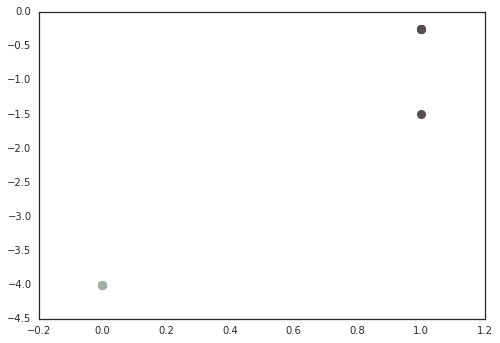

In [7]:
plt.clf()
for i, ds_hps in enumerate(linear_best_params_by_dataset):
    plt.scatter([i] * len(ds_hps), np.log10([s_hps["margin"] for s_hps in ds_hps]), edgecolor=cool_contrasting_cmap[i],
                facecolor=cool_contrasting_cmap[i], linewidth=2, s=50)

for i, ds_hps in enumerate(squared_best_params_by_dataset):
    plt.scatter([i + 0.3] * len(ds_hps), np.log10([s_hps["margin"] for s_hps in ds_hps]), edgecolor=cool_contrasting_cmap[i],
                facecolor="None", linewidth=2, s=50)

plt.axhline(np.log10(min(params["margin"])), color="red", linestyle="--", label=r"$\log_{10}(\epsilon)$ range min")
plt.axhline(np.log10(max(params["margin"])), color="blue", linestyle="--", label=r"$\log_{10}(\epsilon)$ range max")
plt.xlim([-1, len(datasets)])
plt.ylim([np.log10(min(params["margin"])) - 0.1, np.log10(max(params["margin"])) + 0.2])
plt.xlabel("Dataset")
plt.xticks(range(len(datasets)), [d.name for d in datasets], rotation=90)
plt.ylabel(r"$\log_{10}(\epsilon)$")
plt.title("Selected margin values")

plt.scatter([-100], [-100], label="mmit.linear.hinge", facecolor="black", edgecolor="black", linewidth=2, s=50)
plt.scatter([-100], [-100], label="mmit.squared.hinge", facecolor="None", edgecolor="black", linewidth=2, s=50)
plt.legend()

plt.gcf().set_size_inches(13, 10)
plt.savefig("selected_margins.pdf", bbox_inches="tight")
plt.show()

### Alpha

max alpha 100


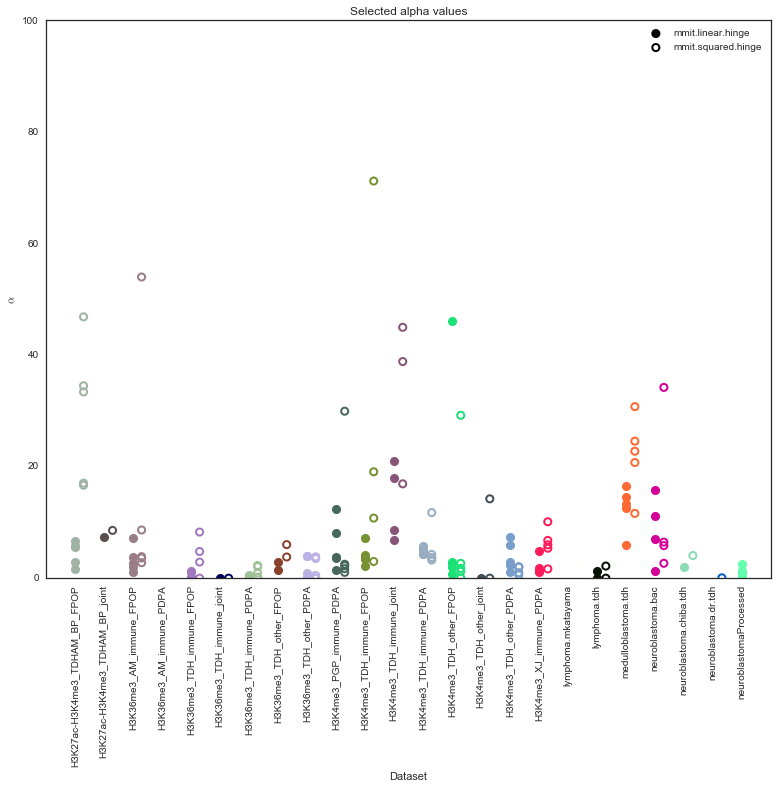

In [85]:
plt.clf()
max_alpha = -1
for i, ds_hps in enumerate(linear_best_params_by_dataset):
    alphas = [s_hps["alpha"] for s_hps in ds_hps]
    plt.scatter([i] * len(ds_hps), alphas, edgecolor=cool_contrasting_cmap[i],
                facecolor=cool_contrasting_cmap[i], linewidth=2, s=50)
    max_alpha = max(max_alpha, min(max(alphas), 100))
    
for i, ds_hps in enumerate(squared_best_params_by_dataset):
    alphas = [s_hps["alpha"] for s_hps in ds_hps]
    plt.scatter([i + 0.3] * len(ds_hps), alphas, edgecolor=cool_contrasting_cmap[i],
                facecolor="None", linewidth=2, s=50)
    max_alpha = max(max_alpha, min(max(alphas), 100))

#plt.axhline(min(params["alpha"]), color="red", linestyle="--", label="$\alpha$ range min")
#plt.axhline(max(params["alpha"]), color="blue", linestyle="--", label="$\alpha$ range max")
print("max alpha", max_alpha)
plt.xlim([-1, len(datasets)])
plt.ylim([0., max_alpha + 0.2])
plt.xlabel("Dataset")
plt.xticks(range(len(datasets)), [d.name for d in datasets], rotation=90)
plt.ylabel(r"$\alpha$")
plt.title("Selected alpha values")

plt.scatter([-100], [-100], label="mmit.linear.hinge", facecolor="black", edgecolor="black", linewidth=2, s=50)
plt.scatter([-100], [-100], label="mmit.squared.hinge", facecolor="None", edgecolor="black", linewidth=2, s=50)
plt.legend()

plt.gcf().set_size_inches(13, 10)
plt.savefig("selected_alphas.pdf", bbox_inches="tight")
plt.show()

## Model lengths

IOError: [Errno 2] No such file or directory: u'./predictions/mmit.squared.hinge/neuroblastomaProcessed/models.tsv'

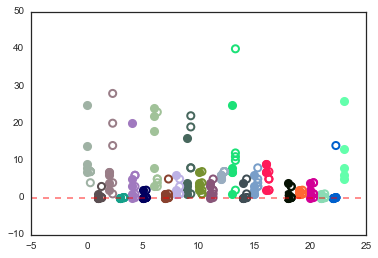

In [86]:
plt.clf()
plt.axhline(0.0, color="red", linestyle="--", alpha=0.5)
max_len = 0
for i, ds in enumerate(datasets):
    model_lengths = [int(l.split("\t")[1].count("Node")) for l in open(join("./predictions/mmit.linear.hinge", ds.name, "models.tsv"))]
    plt.scatter([i] * len(model_lengths), model_lengths, edgecolor=cool_contrasting_cmap[i],
                facecolor=cool_contrasting_cmap[i], linewidth=2, s=50)
    max_len = max(max_len, max(model_lengths))
for i, ds in enumerate(datasets):
    model_lengths = [int(l.split("\t")[1].count("Node")) for l in open(join("./predictions/mmit.squared.hinge", ds.name, "models.tsv"))]
    plt.scatter([i + 0.3] * len(model_lengths), model_lengths, edgecolor=cool_contrasting_cmap[i],
                facecolor="None", linewidth=2, s=50)
    max_len = max(max_len, max(model_lengths))

plt.xlabel("Dataset")
plt.xlim([-1, len(datasets)])
plt.ylim([-1, max_len + 1])
plt.xticks(range(len(datasets)), [d.name for d in datasets], rotation=90)
plt.ylabel("Number of rules in the tree")
plt.title("Size of the models for each dataset")

plt.scatter([-100], [-100], label="mmit.linear.hinge", facecolor="black", edgecolor="black", linewidth=2, s=50)
plt.scatter([-100], [-100], label="mmit.squared.hinge", facecolor="None", edgecolor="black", linewidth=2, s=50)
plt.legend()

plt.gcf().set_size_inches(13, 10)
plt.savefig("model_sizes.pdf", bbox_inches="tight")
plt.show()

### CV score with respect to alpha

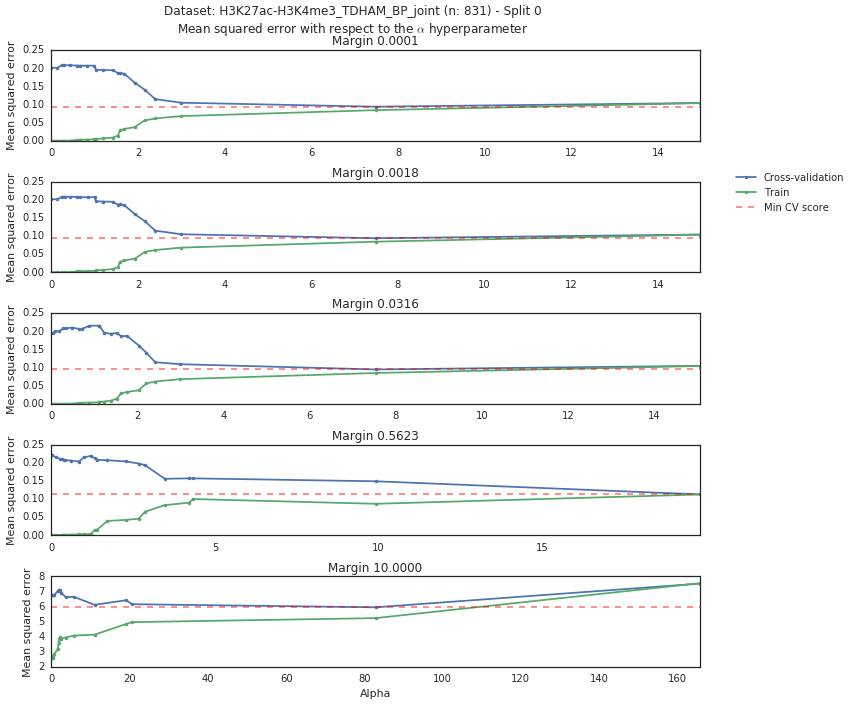

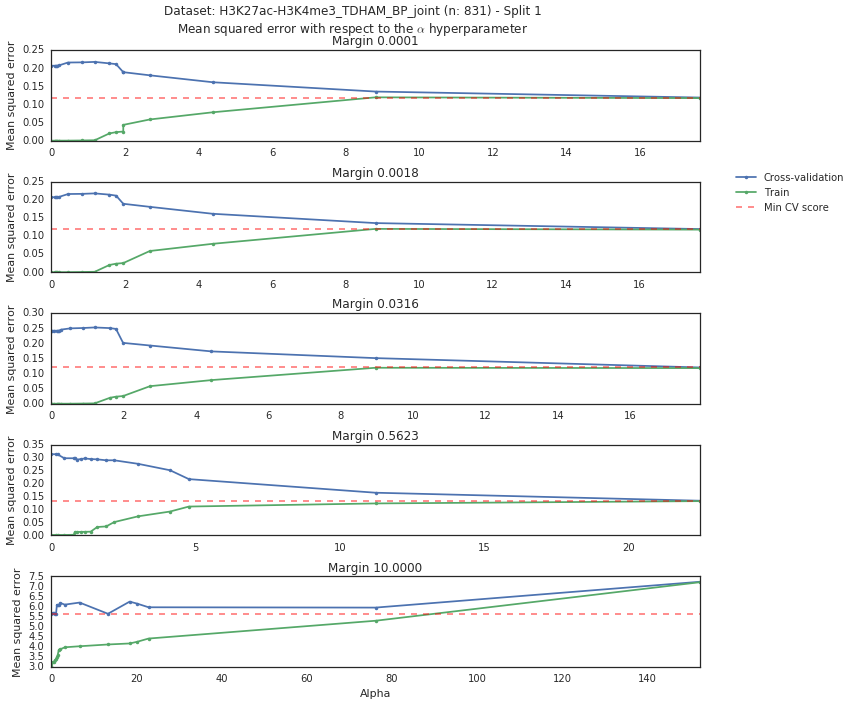

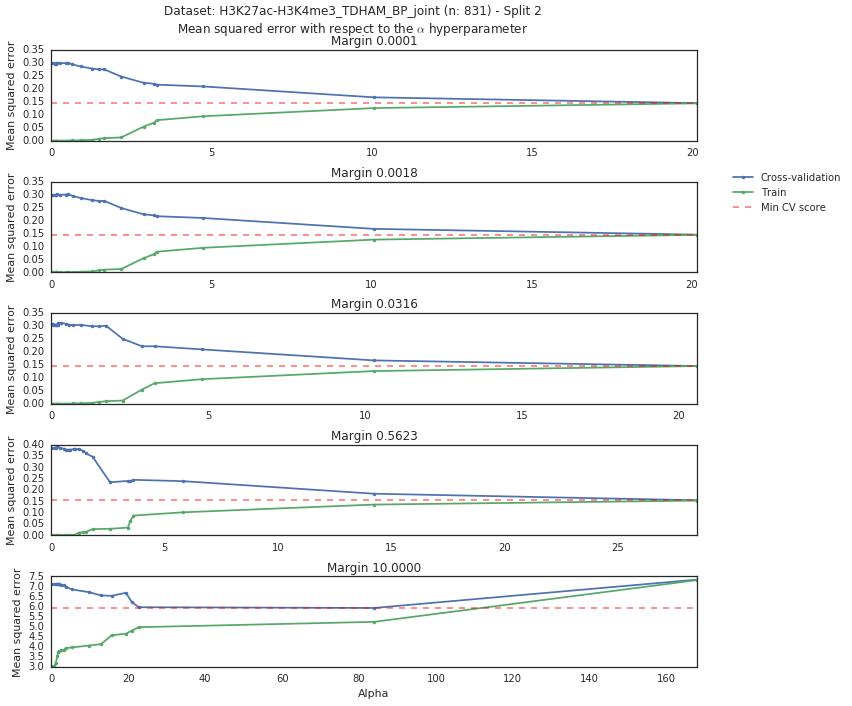

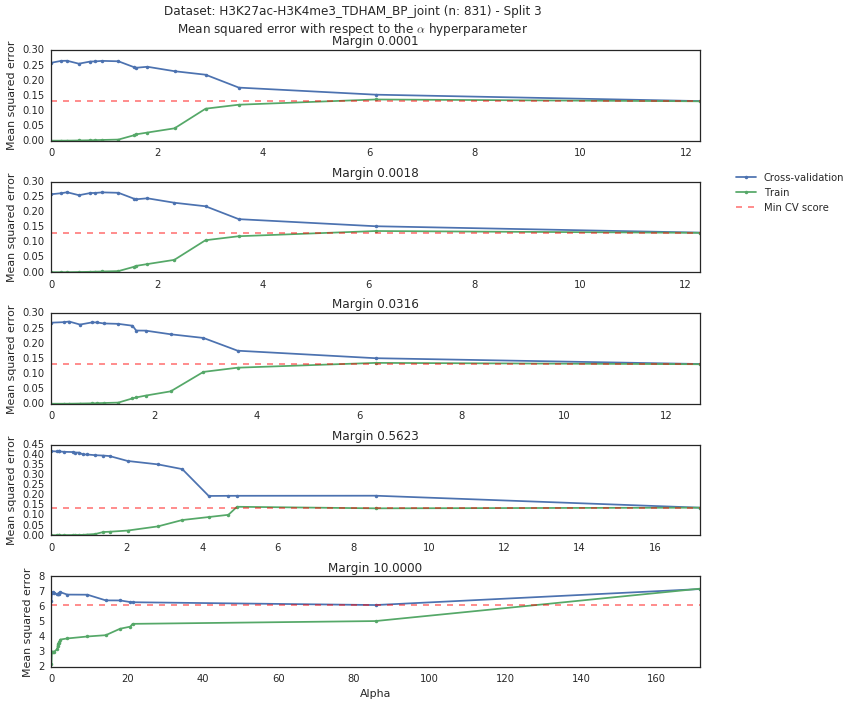

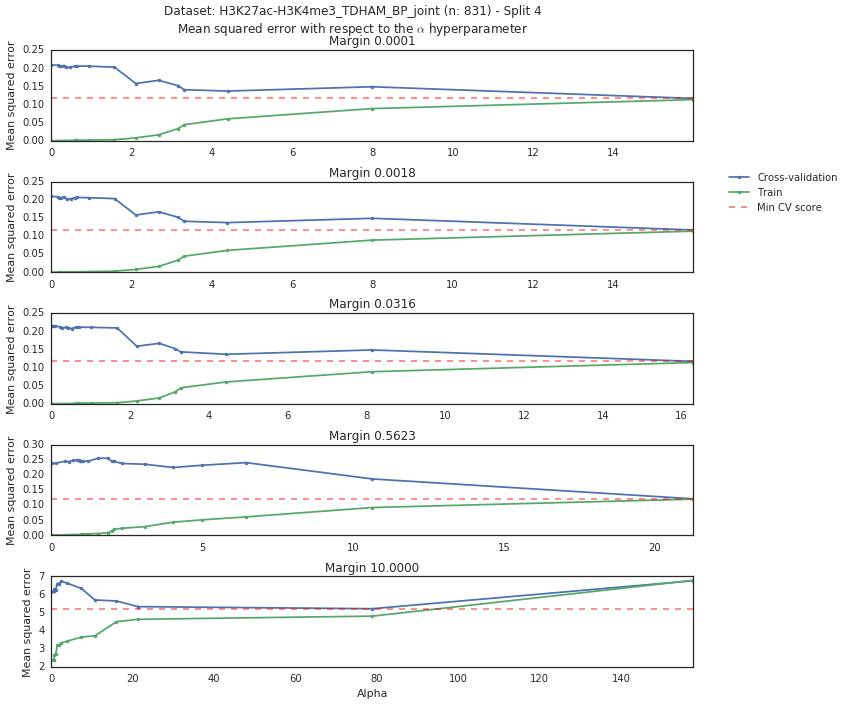

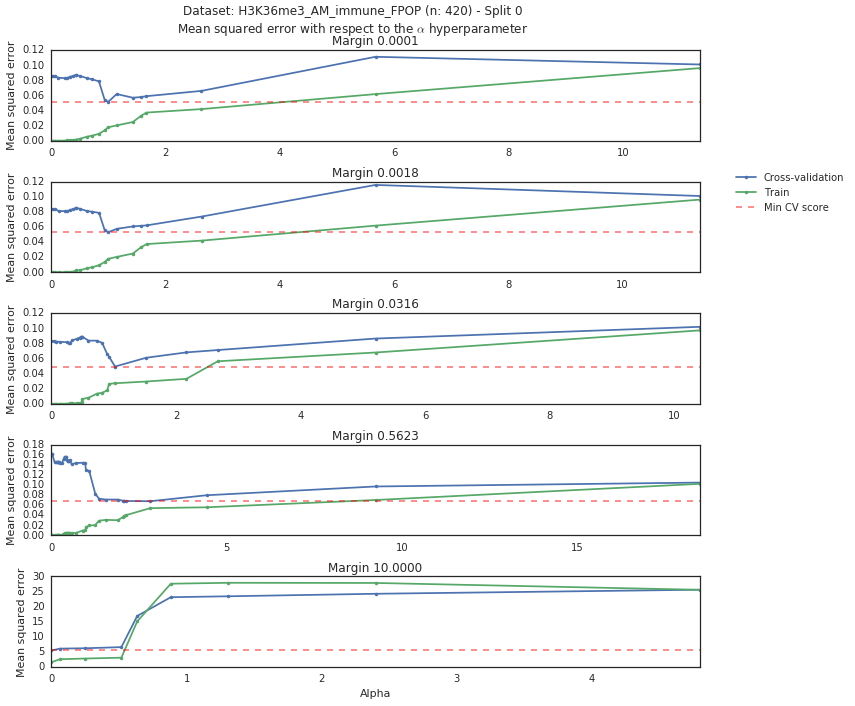

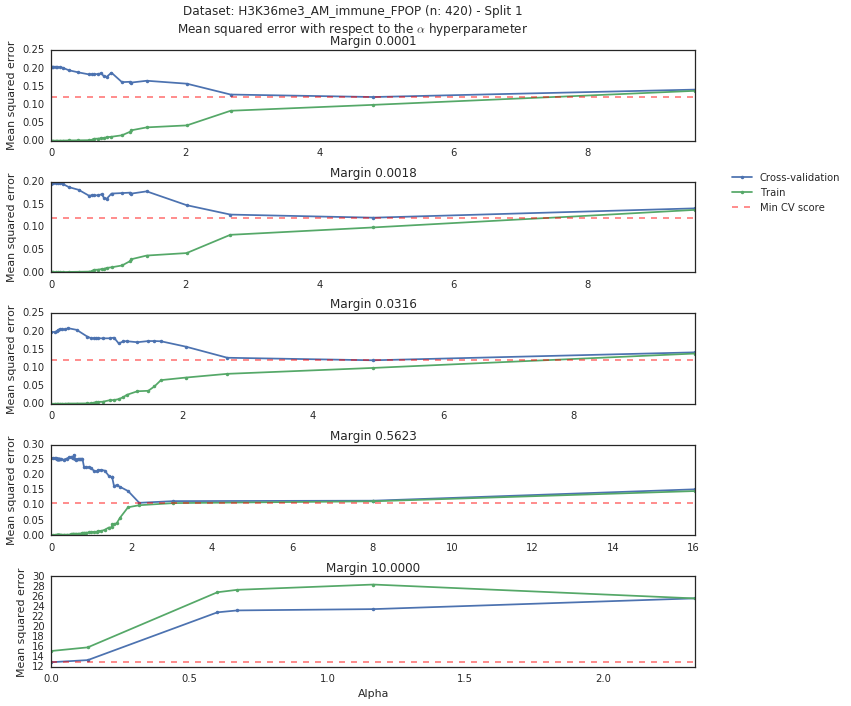

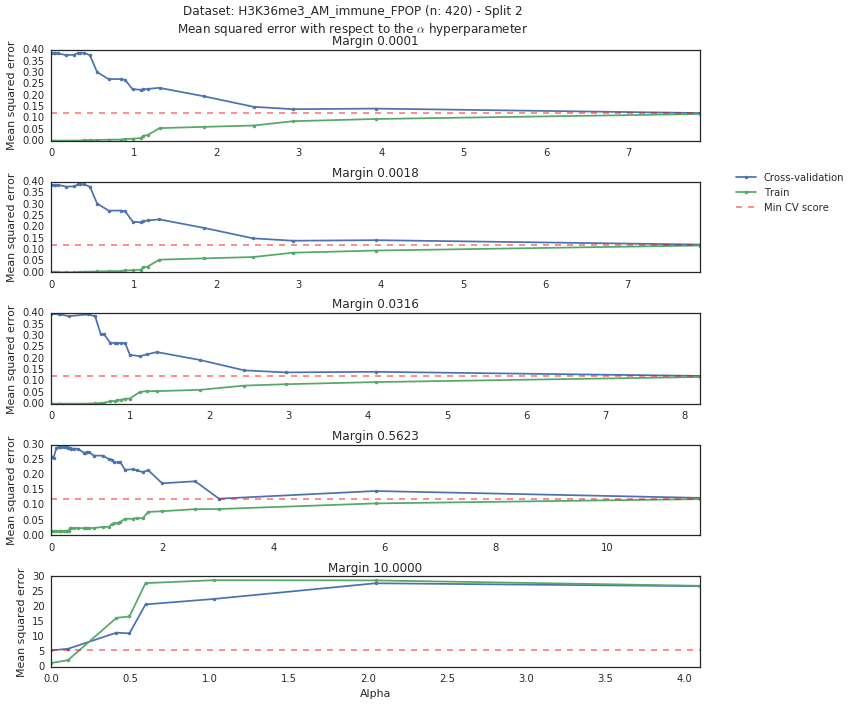

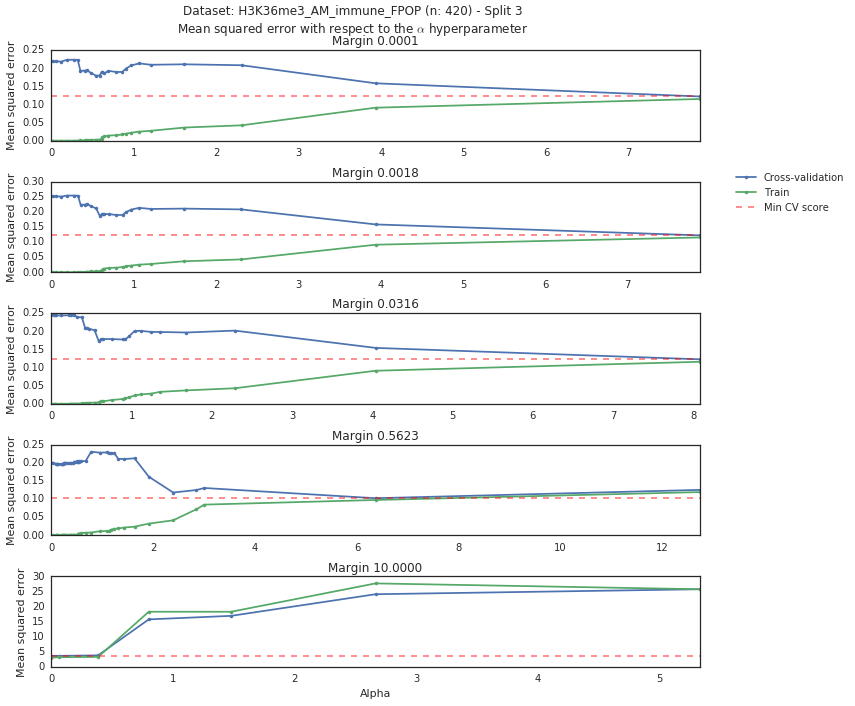

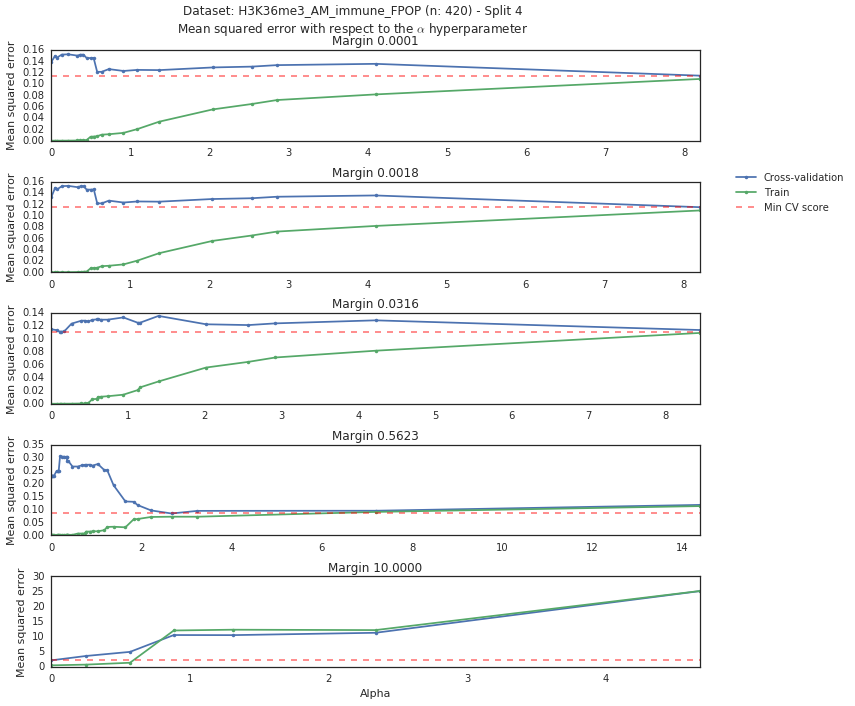

In [8]:
for i, ds_cv_results in enumerate(linear_cv_results_by_dataset):
    
    for j, split_cv_results in enumerate(ds_cv_results):
        
        margin_values = np.array([r[0]["margin"] for r in split_cv_results])
        alpha_values = np.array([r[0]["alpha"] for r in split_cv_results])
        cv_score_values = np.array([r[1]["cv"] for r in split_cv_results]) * -1  # Convert negative MSE to MSE
        train_score_values = np.array([r[1]["train"] for r in split_cv_results]) * -1  # Convert negative MSE to MSE
                
        plt.clf()
        f, subplots = plt.subplots(len(np.unique(margin_values)))
        f.set_size_inches(10, 10)
            
        for k, margin in enumerate(np.unique(margin_values)):
            m_alphas = alpha_values[np.isclose(margin_values, margin)]
            m_cv_scores = cv_score_values[np.isclose(margin_values, margin)]
            m_train_scores = train_score_values[np.isclose(margin_values, margin)]
            
            # What is the maximum alpha value besides infinity
            non_inf_max = np.max(m_alphas[~np.isinf(m_alphas)])
            m_alphas[np.isinf(m_alphas)] = non_inf_max * 2
            
            sorter = np.argsort(m_alphas)
            m_alpha = m_alphas[sorter]
            m_cv_scores = m_cv_scores[sorter]
            m_train_scores = m_train_scores[sorter]
            
            subplots[k].plot(m_alpha, m_cv_scores, label="Cross-validation", marker=".")
            subplots[k].plot(m_alpha, m_train_scores, label="Train", marker=".")
            subplots[k].axhline(m_cv_scores.min(), linestyle="--", color="red", alpha=0.5, label="Min CV score")
            subplots[k].set_ylabel("Mean squared error")
            subplots[k].set_xlim(0, non_inf_max * 2)
            subplots[k].set_title("Margin {0:.4f}".format(margin))
    
        plt.xlabel("Alpha")
        #subplots[0].set_title("mmit.linear.hinge - {0!s} ({1:d} examples) - MSE vs alpha".format(datasets[i].name, 
        #                                                                                 datasets[i].n_examples))
        plt.legend(bbox_to_anchor=(1.05, 5.5), loc=2, borderaxespad=0.)
        plt.suptitle("Dataset: {0!s} (n: {1:d}) - Split {2:d}\nMean squared error with respect to the $\\alpha$"
                     " hyperparameter".format(datasets[i].name, datasets[i].n_examples, j))
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.savefig("mse_vs_alpha_{0!s}_split_{1:d}.pdf".format(datasets[i].name, j), bbox_inches="tight")
        plt.show()